In [2]:
!pip freeze > requirements.txt # Save the requirements in a file for jpyyer notebook

zsh:1: /Users/erdo/Desktop/vub-mac-pro-14/second-year/second-semester/bioinformatics/ReProduceProject/bioEnv/bin/pip: bad interpreter: /Users/erdo/Desktop/vub-mac-pro-14/second-year/second-semester/bioinformatics/project/bioEnv/bin/python3.11: no such file or directory


In [15]:
%pip install matplotlib # Install matplotlib for jupyter notebook



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt
import json

In [53]:
# Function to create a time-series for a single column of data
def create_time_series(single_col, num_splits, time_lag, max_lag):
    segment_length = len(single_col) // num_splits
    time_series = []
    for index in range(num_splits):
        # Extract a segment of the data with a time lag
        segment = single_col[index*segment_length+time_lag : segment_length+index*segment_length+time_lag-max_lag]
        # Append the segment to the time series
        time_series.extend(segment)
    return pd.Series(time_series)


# Function to preprocess the gene expression data
def preprocess_expression_data(expression_matrix, num_splits, max_lag):
    new_columns = []
    for gene_name in expression_matrix.columns:
        for lag_index in range(max_lag):
            # Create a time-series for each gene
            new_column = create_time_series(expression_matrix[gene_name], num_splits, lag_index, max_lag)
            new_column.name = gene_name + '_' + str(max_lag-lag_index)
            new_columns.append(new_column)
    # Concatenate all new columns into a DataFrame
    preprocessed_data = pd.concat(new_columns, axis=1)
    return preprocessed_data

# Function considering time lag in time-series expression. choose the max() candidate representing the importance
def importance_regulatory_link(current_g, g_importance_names, g_importance_values):
    data = {key: value for key, value in zip(g_importance_names, g_importance_values)}
    max_values = {}
    for key, value in data.items():
        group = key.split('_')[0]
        # select the maximum candidate
        if group not in max_values or value > max_values[group]:
            if group == current_g:
                continue
            max_values[group + "\t" + current_g] = value
    return max_values
        
def new_importance_feature(set_feature, scores):
    list_lij = {}
    l = {}
    total_sum = sum(scores)
    for i in range(len(scores)):
        for key in set_feature[i].keys():
            l[key] = set_feature[i][key] * (1 - scores[i] / total_sum)
        list_lij.update(l)
    return list_lij

def rank_globally(score_local_in_model,score_local_out_model,l1_in,l2_out):
    new_scores = {}
    for key in l1_in.keys():
        gene = key.split('\t')[1]
        # Calculate the correlation between the scores of the local-in/out models
        correlation = np.corrcoef(score_local_in_model[gene], score_local_out_model[gene])[0, 1]
        # If the correlation is greater than 0.5, store the scores for both models. Otherwise, store the scores for the local-in model only.
        if correlation > 0.5:
            # overall importance
            new_scores[key] = np.sqrt(l1_in[key] * l2_out[key])
        else:
            new_scores[key] = l1_in[key]
    return new_scores


In [54]:
# Main function to run the BiXGBoost algorithm
def run_BiXGBoost(expression_file, num_samples):
    # Read the gene expression data from a file
    gene_expression_data = pd.read_csv(expression_file,  sep='\t')
    importance_local_in = []
    score_local_out_model = []
    score_local_in_model = []
    importance_local_out = []
    # Initialize lists to store the AUROC and AUPR for each gene
    auroc_scores_in = []
    aupr_scores_in = []
    auroc_scores_out = []
    aupr_scores_out = []
    # Loop over each gene in the data
    for index in range(len(gene_expression_data.columns)):
        # Copy the gene expression data
        copied_data = gene_expression_data.copy()
        
        # Create a time-series for the target gene for local-in model
        target_gene_series_in = create_time_series(gene_expression_data[gene_expression_data.columns[index]], num_samples, 2, 2)
        
        # Normalize the target gene data
        normalized_target_gene_in = (target_gene_series_in - target_gene_series_in.mean()) / target_gene_series_in.std()

        # Create a time-series for the target gene for local-out model
        target_gene_series_out = create_time_series(gene_expression_data[gene_expression_data.columns[index]], num_samples, 0, 2)
        
        # Normalize the target gene data for local-out model
        normalized_target_gene_out = (target_gene_series_out - target_gene_series_out.mean()) / target_gene_series_out.std()
        
        # Preprocess the gene expression data
        preprocessed_data_in = preprocess_expression_data(copied_data, num_samples, 2)
        preprocessed_data_out = preprocess_expression_data(copied_data, num_samples, 2)
        
        # Create and train an XGBoost for local-in-model
        xgboost_model_in = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
        xgboost_model_in.fit(preprocessed_data_in, normalized_target_gene_in)
        
        # Importance regulatory link
        set_features = importance_regulatory_link(gene_expression_data.columns[index],preprocessed_data_in.columns,xgboost_model_in.feature_importances_)
        importance_local_in.append(set_features)
        
        # Evaluate the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared
        predictions_in = xgboost_model_in.predict(preprocessed_data_in)
        mse = mean_squared_error(normalized_target_gene_in, predictions_in)
        score_local_in_model.append(mse)
        
        # Create and train an XGBoost for local-out model
        xgboost_model_out = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
        xgboost_model_out.fit(preprocessed_data_out, normalized_target_gene_out)
        
        # Importance regulatory link
        set_features = importance_regulatory_link(gene_expression_data.columns[index],preprocessed_data_out.columns,xgboost_model_out.feature_importances_)
        importance_local_out.append(set_features)
        
        # Evaluate the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared
        predictions_out = xgboost_model_out.predict(preprocessed_data_out)
        mse_out = mean_squared_error(normalized_target_gene_out, predictions_out)
        score_local_out_model.append(mse_out)
 
    # Modified importance for feature
    l1 = new_importance_feature(importance_local_in, score_local_in_model)
    l2 = new_importance_feature(importance_local_out, score_local_out_model)
    
    local_in = {key: value for key, value in zip(gene_expression_data.columns, score_local_in_model)}
    local_out = {key: value for key, value in zip(gene_expression_data.columns, score_local_out_model)}

    # Rank globally
    scores = rank_globally(local_in,local_out,l1,l2)
    
    return scores

In [51]:
scores = run_BiXGBoost('data/Ecoil/cold_time_3_replice.tsv', 3)

# saving into a file
with open('output_cold_time_3_replice.csv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    for key, value in scores.items():
        writer.writerow([key.split('\t')[0],key.split('\t')[1], value])
print('file saved')

file saved


In [72]:
# This section is the same as the main run_BiXGBoost function with some changes to perform the evaluation with metrics: AUPR AUROC

# This function are steps that were duplicated in the code.
def preprocess_target_gene(data, num_samples, index):
    copied_data = data.copy()
    # Create a time-series for the target gene
    target_gene_series = create_time_series(data[data.columns[index]], num_samples, index, 2)
    # normalize target gene
    normalized_target_gene_in = (target_gene_series - target_gene_series.mean()) / target_gene_series.std()
    # preprocess data
    preprocessed_data = preprocess_expression_data(copied_data, num_samples, 2)
    return preprocessed_data, normalized_target_gene_in

num_samples = 10
threshold = 0.025
auroc_scores = []
aupr_scores = []

# Read network
gene_expression_data = pd.read_csv('data/DREAM100/insilico_size100_5_timeseries.txt',  sep='\t')

# 80% train, 20% test
split = int(len(gene_expression_data) * 0.8)

# Split the data into train and test sets
train_gene_expression_data = gene_expression_data[:split]
test_gene_expression_data = gene_expression_data[split:]

for index in range(len(gene_expression_data.columns)):
    #---local-in model----#
    # preprocess for train data
    data, target_gene = preprocess_target_gene(train_gene_expression_data, num_samples, 2)
    # preprocess for test data
    data_test, target_gene_test = preprocess_target_gene(gene_expression_data, num_samples, 2)
       
    # Train
    xgboost_model_in = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
    xgboost_model_in.fit(data, target_gene)
        
    # Predict
    y_pred_in = xgboost_model_in.predict(data_test)
    score_in = mean_squared_error(target_gene_test, y_pred_in)
        
    y_true = {key: 1 if value >= threshold else 0 for key, value in target_gene_test.items()}

    precision, recall, _ = precision_recall_curve(list(y_true.values()), y_pred_in) 
    aupr_in = auc(recall, precision)
    auroc_in = roc_auc_score(list(y_true.values()), y_pred_in)
    
    #---local-out model----#
    # preprocess for train data
    data, target_gene = preprocess_target_gene(train_gene_expression_data, num_samples, 0)
    # preprocess for test data
    data_test, target_gene_test = preprocess_target_gene(gene_expression_data, num_samples, 0)
       
    # Train
    xgboost_model_in = xgb.XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.0001, subsample=0.8, seed=42)
    xgboost_model_in.fit(data, target_gene)
        
    # Predict
    y_pred_out = xgboost_model_in.predict(data_test)
    score_out = mean_squared_error(target_gene_test, y_pred_out)
        
    # Calculate the correlation between the scores of the local-in/out models
    correlation = np.corrcoef(score_in, score_out)[0, 1]
    # If the correlation is greater than 0.5, store the scores for both models. Otherwise, store the scores for the local-in model only.
    if correlation > 0.5:
        # new score
        new_pred = np.sqrt(y_pred_in * y_pred_out)
        y_true = {key: 1 if value >= threshold else 0 for key, value in target_gene_test.items()}
        # estimate aupr and auroc of the new score
        precision, recall, _ = precision_recall_curve(list(y_true.values()), new_pred)
        aupr = auc(recall, precision)
        auroc = roc_auc_score(list(y_true.values()), y_pred_out)
        auroc_scores.append(auroc)
        aupr_scores.append(aupr)
            
    else:
        # only consider local-in model results
        auroc_scores.append(auroc_in)
        aupr_scores.append(aupr_in)

print('AUPR: ' + str(np.mean(auroc_scores)))
print('AUROC: ' + str(np.mean(aupr_scores)))

'''
in_silico_10_1_timeseries
AUPR: 0.9131205673758865
AUROC: 0.921685848508721

insilico_size10_2_timeseries
AUPR: 0.8486554096310194
AUROC: 0.8382573515460257

insilico_size10_3_timeseries
AUPR: 0.9443750000000002
AUROC: 0.93413098947441

insilico_size10_4_timeseries
AUPR: 0.98125
AUROC: 0.9862321447635315

insilico_size10_5_timeseries
AUPR: 0.9654731457800511
AUROC: 0.9751374838335847

insilico_size100_1_timeseries
AUPR: 0.8298181006584092
AUROC: 0.792821925691904

insilico_size100_2_timeseries
AUPR: 0.8925839707349518
AUROC: 0.9151535682941205

insilico_size100_3_timeseries
AUPR: 0.8122222222222223
AUROC: 0.7990852488587029

insilico_size100_4_timeseries
AUPR: 0.9527559055118108
AUROC: 0.9327155456857112

insilico_size100_5_timeseries
AUPR: 0.8955473719450957
AUROC: 0.9194673233692146
'''

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_

C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\anaconda\envs\ml-2223\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

AUPR: 0.8955473719450957
AUROC: 0.9194673233692146


C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\ACER\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


'\nin_silico_10_1_timeseries\nAUPR: 0.9131205673758865\nAUROC: 0.921685848508721\n\ninsilico_size10_2_timeseries\nAUPR: 0.8486554096310194\nAUROC: 0.8382573515460257\n\ninsilico_size10_3_timeseries\nAUPR: 0.9443750000000002\nAUROC: 0.93413098947441\n\ninsilico_size10_4_timeseries\nAUPR: 0.98125\nAUROC: 0.9862321447635315\n\ninsilico_size10_5_timeseries\nAUPR: 0.9654731457800511\nAUROC: 0.9751374838335847\n\ninsilico_size100_1_timeseries\nAUPR: 0.8298181006584092\nAUROC: 0.792821925691904\n\ninsilico_size100_2_timeseries\nAUPR: 0.8925839707349518\nAUROC: 0.9151535682941205\n\ninsilico_size100_3_timeseries\nAUPR: 0.8122222222222223\nAUROC: 0.7990852488587029\n\nAUPR: 0.9527559055118108\nAUROC: 0.9327155456857112\n'

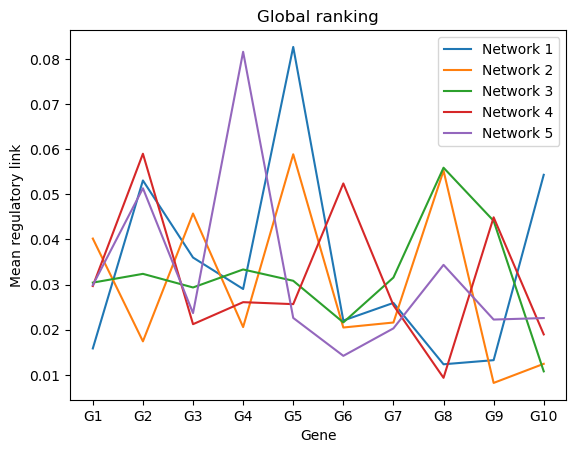

In [152]:
# PLOT: DREAM4 for output_insilico_size10 samples 5
import pandas as pd
import matplotlib.pyplot as plt

df_1 = pd.read_csv('output_insilico_size10_1.csv', delimiter='\t', header=None)
df_2 = pd.read_csv('output_insilico_size10_2.csv', delimiter='\t', header=None)
df_3 = pd.read_csv('output_insilico_size10_3.csv', delimiter='\t', header=None)
df_4 = pd.read_csv('output_insilico_size10_4.csv', delimiter='\t', header=None)
df_5 = pd.read_csv('output_insilico_size10_5.csv', delimiter='\t', header=None)

column_names = ['Gene1', 'Gene2', 'Regulatory link']
df_1.columns = column_names
df_2.columns = column_names
df_3.columns = column_names
df_4.columns = column_names
df_5.columns = column_names

grouped1 = df_1.groupby('Gene2', sort=False)['Regulatory link'].mean()
grouped2 = df_2.groupby('Gene2', sort=False)['Regulatory link'].mean()
grouped3 = df_3.groupby('Gene2', sort=False)['Regulatory link'].mean()
grouped4 = df_4.groupby('Gene2', sort=False)['Regulatory link'].mean()
grouped5 = df_5.groupby('Gene2', sort=False)['Regulatory link'].mean()

# Plotting the grouped variables
plt.plot(grouped1.index, grouped1.values, label='Network 1')
plt.plot(grouped2.index, grouped2.values, label='Network 2')
plt.plot(grouped3.index, grouped3.values, label='Network 3')
plt.plot(grouped4.index, grouped4.values, label='Network 4')
plt.plot(grouped5.index, grouped5.values, label='Network 5')

# Customize the plot
plt.xlabel('Gene')
plt.ylabel('Mean regulatory link')
plt.title('Global ranking')
plt.legend()

# Show the plot
plt.show()


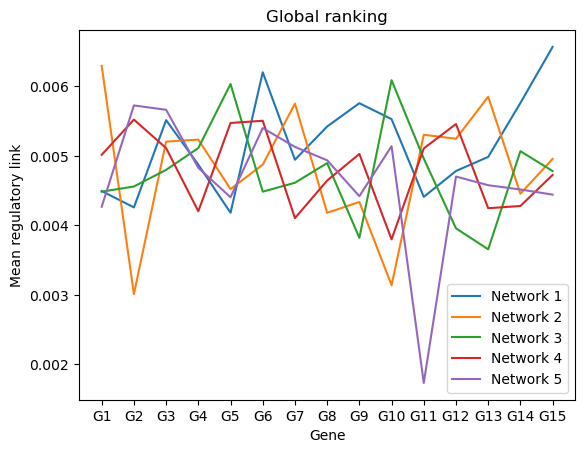

In [153]:
# PLOT: DREAM4 for output_insilico_size100 samples 10
import pandas as pd
import matplotlib.pyplot as plt

df_1 = pd.read_csv('output_insilico_size100_1_timeseries.csv', delimiter='\t', header=None)
df_2 = pd.read_csv('output_insilico_size100_2_timeseries.csv', delimiter='\t', header=None)
df_3 = pd.read_csv('output_insilico_size100_3_timeseries.csv', delimiter='\t', header=None)
df_4 = pd.read_csv('output_insilico_size100_4_timeseries.csv', delimiter='\t', header=None)
df_5 = pd.read_csv('output_insilico_size100_5_timeseries.csv', delimiter='\t', header=None)

column_names = ['Gene1', 'Gene2', 'Regulatory link']
df_1.columns = column_names
df_2.columns = column_names
df_3.columns = column_names
df_4.columns = column_names
df_5.columns = column_names

grouped1 = df_1.groupby('Gene2', sort=False)['Regulatory link'].mean().head(15)
grouped2 = df_2.groupby('Gene2', sort=False)['Regulatory link'].mean().head(15)
grouped3 = df_3.groupby('Gene2', sort=False)['Regulatory link'].mean().head(15)
grouped4 = df_4.groupby('Gene2', sort=False)['Regulatory link'].mean().head(15)
grouped5 = df_5.groupby('Gene2', sort=False)['Regulatory link'].mean().head(15)

# Plotting the grouped variables
plt.plot(grouped1.index, grouped1.values, label='Network 1')
plt.plot(grouped2.index, grouped2.values, label='Network 2')
plt.plot(grouped3.index, grouped3.values, label='Network 3')
plt.plot(grouped4.index, grouped4.values, label='Network 4')
plt.plot(grouped5.index, grouped5.values, label='Network 5')

# Customize the plot
plt.xlabel('Gene')
plt.ylabel('Mean regulatory link')
plt.title('Global ranking')
plt.legend()

# Show the plot
plt.show()


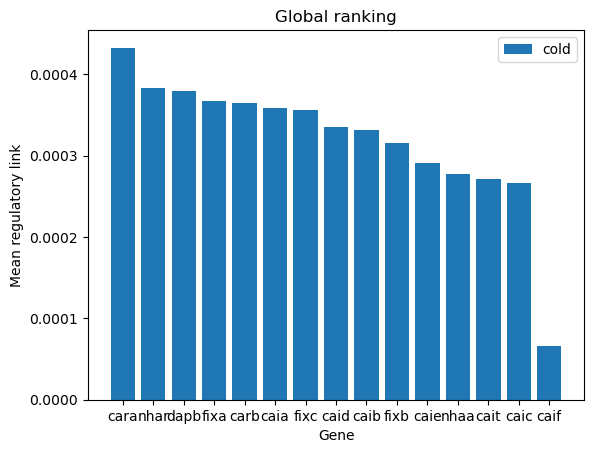

In [4]:
# PLOT: E.Coli for output_cold_time_3_replice cold environment samples 3
import pandas as pd
import matplotlib.pyplot as plt

df_1 = pd.read_csv('output_cold_time_3_replice.csv', delimiter='\t', header=None)

column_names = ['Gene1', 'Gene2', 'Regulatory link']
df_1.columns = column_names

group1 = df_1.groupby('Gene2', sort=False)['Regulatory link'].mean().head(15)
sorted_df = group1.sort_values(ascending=False)

# Plotting the grouped variables
plt.bar(sorted_df.index, sorted_df.values, label='cold')
#plt.scatter(group1.index, group1.values, label='cold')

# Customize the plot
plt.xlabel('Gene')
plt.ylabel('Mean regulatory link')
plt.title('Global ranking')
plt.legend()

# Show the plot
plt.show()